# **Machine Learning for Stock Price Forecasting and Portfolio Optimization**

# **Importing Libraries and Dependencies**

In [2]:
# Importing Libraries and Dependencies
!pip install yfinance xgboost seaborn 
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from IPython.display import display, Markdown
import warnings
warnings.filterwarnings('ignore')

# Setting plots style for professional aesthetics
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('talk', font_scale=1.1)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['axes.edgecolor'] = '#222222'
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['font.family'] = 'DejaVu Sans'

print("Libraries imported successfully!")

  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)
Libraries imported successfully!


# **Data Download**

In [3]:
# Getting User Input

def user_input():
        ticker = input("Enter the Stock Ticker : ").strip().upper()
        extension = ".NS"
        ticker = ticker + extension
        start_date = "2015-01-01"
        end_date = pd.to_datetime("today").normalize()
        print("User Input Saved Succesfully")
        return ticker , start_date, end_date

# Calling the Function

ticker, start_date, end_date = user_input()

User Input Saved Succesfully


In [4]:
# Downloading the data

def download_stock_data(ticker, start_date, end_date):
    """
    Downloads historical stock data from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'RELIANCE.NS').
        start_date (str): The start date in 'YYYY-MM-DD' format.
        end_date (str): The end date in 'YYYY-MM-DD' format.

    Returns:
        pd.DataFrame: DataFrame containing the stock data, or None if download fails.
    """
    try:
        data = yf.download(ticker, start=start_date, end=end_date, group_by="column")


        if data.empty:
            print(f"No data found for ticker {ticker}. Please check the symbol and date range.")
            return None
        print("Data downloaded successfully.")
        return data
    except Exception as e:
        print(f"An error occurred while downloading data for {ticker}: {e}")
        return None


# Calling the function

stock_data = download_stock_data(ticker,start_date,end_date)

stock_data.head()
stock_data.tail()

[*********************100%***********************]  1 of 1 completed

Data downloaded successfully.


Price,Close,High,Low,Open,Volume
Ticker,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS
Date,,,,,
2025-09-01,1499.400024,1503.400024,1476.199951,1476.699951,4546057
2025-09-02,1498.699951,1512.800049,1486.300049,1499.400024,5218763
2025-09-03,1479.099976,1501.900024,1473.000000,1500.000000,4623483
2025-09-04,1463.000000,1484.000000,1460.099976,1484.000000,5787724
2025-09-05,1444.599976,1472.699951,1433.000000,1470.000000,5466487


# **Data Preprocessing**

In [5]:
# Data Preprocessing

def preprocess_and_engineer_features(df):
    """
    Handles missing values and engineers relevant features.
    This function will return a DataFrame with NaNs from the calculations.
    """
    print("\nStarting data preprocessing and feature engineering...")

    df.index = pd.to_datetime(df.index)
    if 'Ticker' in df.columns:
      df = df.drop(columns=['Ticker'])


    raw_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    df[raw_cols] = df[raw_cols].fillna(method='ffill').fillna(method='bfill')
    df['Returns'] = df['Close'].pct_change()

    for lag in [7, 9, 21, 50, 100, 200]:
        df[f'lag_{lag}'] = df['Close'].shift(lag)

    for window in [7, 9, 21, 50, 100, 200]:
        df[f'rolling_mean_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['Close'].rolling(window=window).std()

    df['day'] = df.index.day
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['weekofyear'] = df.index.isocalendar().week.astype(int)

    print("Feature engineering complete.")
    return df

In [6]:
stock_preprocess = preprocess_and_engineer_features(stock_data.copy())

print(stock_preprocess.shape)
print(stock_preprocess.columns)


Starting data preprocessing and feature engineering...
Feature engineering complete.
(2638, 28)
MultiIndex([(           'Close', 'INFY.NS'),
            (            'High', 'INFY.NS'),
            (             'Low', 'INFY.NS'),
            (            'Open', 'INFY.NS'),
            (          'Volume', 'INFY.NS'),
            (         'Returns',        ''),
            (           'lag_7',        ''),
            (           'lag_9',        ''),
            (          'lag_21',        ''),
            (          'lag_50',        ''),
            (         'lag_100',        ''),
            (         'lag_200',        ''),
            (  'rolling_mean_7',        ''),
            (   'rolling_std_7',        ''),
            (  'rolling_mean_9',        ''),
            (   'rolling_std_9',        ''),
            ( 'rolling_mean_21',        ''),
            (  'rolling_std_21',        ''),
            ( 'rolling_mean_50',        ''),
            (  'rolling_std_50',        ''),
   

# **Tabular Analysis**

In [7]:
# Checking the head of data

stock_preprocess.head()

Price,Close,High,Low,Open,Volume,Returns,lag_7,lag_9,lag_21,lag_50,...,rolling_mean_50,rolling_std_50,rolling_mean_100,rolling_std_100,rolling_mean_200,rolling_std_200,day,month,year,weekofyear
Ticker,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,380.634491,382.099651,377.260755,379.583799,2002764,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,1,2015,1
2015-01-02,388.114532,389.242343,380.171804,380.171804,6778320,0.019652,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,2015,1
2015-01-05,384.779449,391.353411,381.232202,387.478439,9937024,-0.008593,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5,1,2015,2
2015-01-06,376.740204,382.677988,372.865232,381.714063,9667316,-0.020893,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6,1,2015,2
2015-01-07,378.542816,380.701998,375.930571,378.822345,7249916,0.004785,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7,1,2015,2


In [8]:
# Checking the tail of the data

stock_preprocess.tail()

Price,Close,High,Low,Open,Volume,Returns,lag_7,lag_9,lag_21,lag_50,...,rolling_mean_50,rolling_std_50,rolling_mean_100,rolling_std_100,rolling_mean_200,rolling_std_200,day,month,year,weekofyear
Ticker,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS,,,,,,...,,,,,,,,,,
Date,,,,,,,,,,,,,,,,,,,,,
2025-09-01,1499.400024,1503.400024,1476.199951,1476.699951,4546057,0.020278,1496.400024,1440.000000,1509.000000,1622.900024,...,1536.641995,69.360357,1530.305970,71.305240,1661.461821,170.502324,1,9,2025,36
2025-09-02,1498.699951,1512.800049,1486.300049,1499.400024,5218763,-0.000467,1487.500000,1496.199951,1469.599976,1584.000000,...,1534.935994,69.220646,1531.203214,70.320813,1659.740968,170.398992,2,9,2025,36
2025-09-03,1479.099976,1501.900024,1473.000000,1500.000000,4623483,-0.013078,1532.099976,1496.400024,1480.500000,1581.599976,...,1532.885994,69.328175,1532.151976,68.944307,1657.924087,170.378034,3,9,2025,36
2025-09-04,1463.000000,1484.000000,1460.099976,1484.000000,5787724,-0.010885,1529.599976,1487.500000,1460.300049,1614.900024,...,1529.847993,68.988268,1532.883036,67.798697,1656.045689,170.446110,4,9,2025,36
2025-09-05,1444.599976,1472.699951,1433.000000,1470.000000,5466487,-0.012577,1529.599976,1532.099976,1436.699951,1616.000000,...,1526.419993,68.878357,1533.266892,67.180134,1654.337108,170.845936,5,9,2025,36


In [9]:
# Info about the data

stock_preprocess.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2638 entries, 2015-01-01 to 2025-09-05
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   (Close, INFY.NS)      2638 non-null   float64
 1   (High, INFY.NS)       2638 non-null   float64
 2   (Low, INFY.NS)        2638 non-null   float64
 3   (Open, INFY.NS)       2638 non-null   float64
 4   (Volume, INFY.NS)     2638 non-null   int64  
 5   (Returns, )           2637 non-null   float64
 6   (lag_7, )             2631 non-null   float64
 7   (lag_9, )             2629 non-null   float64
 8   (lag_21, )            2617 non-null   float64
 9   (lag_50, )            2588 non-null   float64
 10  (lag_100, )           2538 non-null   float64
 11  (lag_200, )           2438 non-null   float64
 12  (rolling_mean_7, )    2632 non-null   float64
 13  (rolling_std_7, )     2632 non-null   float64
 14  (rolling_mean_9, )    2630 non-null   float64
 15  (ro

In [10]:
# Describing all continuous features of  the data

stock_preprocess.describe()

Price,Close,High,Low,Open,Volume,Returns,lag_7,lag_9,lag_21,lag_50,...,rolling_mean_50,rolling_std_50,rolling_mean_100,rolling_std_100,rolling_mean_200,rolling_std_200,day,month,year,weekofyear
Ticker,INFY.NS,INFY.NS,INFY.NS,INFY.NS,INFY.NS,,,,,,...,,,,,,,,,,
count,2638.000000,2638.000000,2638.000000,2638.000000,2.638000e+03,2637.000000,2631.000000,2629.000000,2617.000000,2588.000000,...,2589.000000,2589.000000,2539.000000,2539.000000,2439.000000,2439.000000,2638.000000,2638.000000,2638.000000,2638.000000
mean,951.939461,961.503897,942.422840,952.135664,7.973800e+06,0.000646,950.536601,950.096082,947.775315,940.840533,...,951.919121,41.192866,951.097348,59.231567,948.627527,85.032156,15.725171,6.402578,2019.857847,26.118271
std,505.353783,509.720912,500.847748,505.356945,6.551537e+06,0.016690,505.291176,505.230738,505.215697,503.712864,...,502.064630,30.336585,497.894629,42.197774,487.332508,56.379135,8.801863,3.424159,3.088119,14.944330
min,358.174347,363.997637,352.679171,360.880985,0.000000e+00,-0.161880,358.174347,358.174347,358.174347,358.174347,...,374.325206,5.097915,385.057779,12.225704,389.367287,12.859503,1.000000,1.000000,2015.000000,1.000000
25%,457.623421,464.727615,451.626535,457.927563,4.999405e+06,-0.008138,456.788757,456.638306,455.532349,453.067505,...,456.709012,16.110206,456.190183,23.709319,450.194054,34.718853,8.000000,3.000000,2017.000000,13.000000
50%,688.089081,694.197943,681.243714,686.399417,6.625126e+06,0.000493,687.525818,686.919312,685.792847,680.774658,...,678.971389,32.845750,664.355095,51.220503,691.393905,68.356911,16.000000,6.000000,2020.000000,26.000000
75%,1425.548492,1437.236550,1414.643189,1426.134182,8.881400e+06,0.009622,1424.401062,1424.099976,1421.605591,1414.681427,...,1430.214824,60.215820,1433.599997,84.524444,1422.769614,135.845707,23.000000,9.000000,2023.000000,39.000000
max,1971.954346,1978.610690,1950.160948,1967.763256,1.644050e+08,0.120334,1971.954346,1971.954346,1971.954346,1971.954346,...,1883.485146,161.461677,1867.640542,197.655185,1786.443265,207.726438,31.000000,12.000000,2025.000000,53.000000


# **Exploratory Data Analysis**

In [11]:
# Performing Exploratory data analysis

stock_preprocessed = stock_preprocess.copy()
stock_preprocessed.columns = [col[0] if isinstance(col, tuple) else col for col in stock_preprocessed.columns]

# creating feature for simple and exponential moving averages

smas = [7, 14, 21, 50, 100, 200]
emas = [7,14, 21, 50, 100, 200]


for ma in smas:
    stock_preprocessed[f"SMA_{ma}"] = stock_preprocessed["Close"].rolling(window=ma).mean()


for ma in emas:
    stock_preprocessed[f"EMA_{ma}"] = stock_preprocessed["Close"].ewm(span=ma, adjust=False).mean()




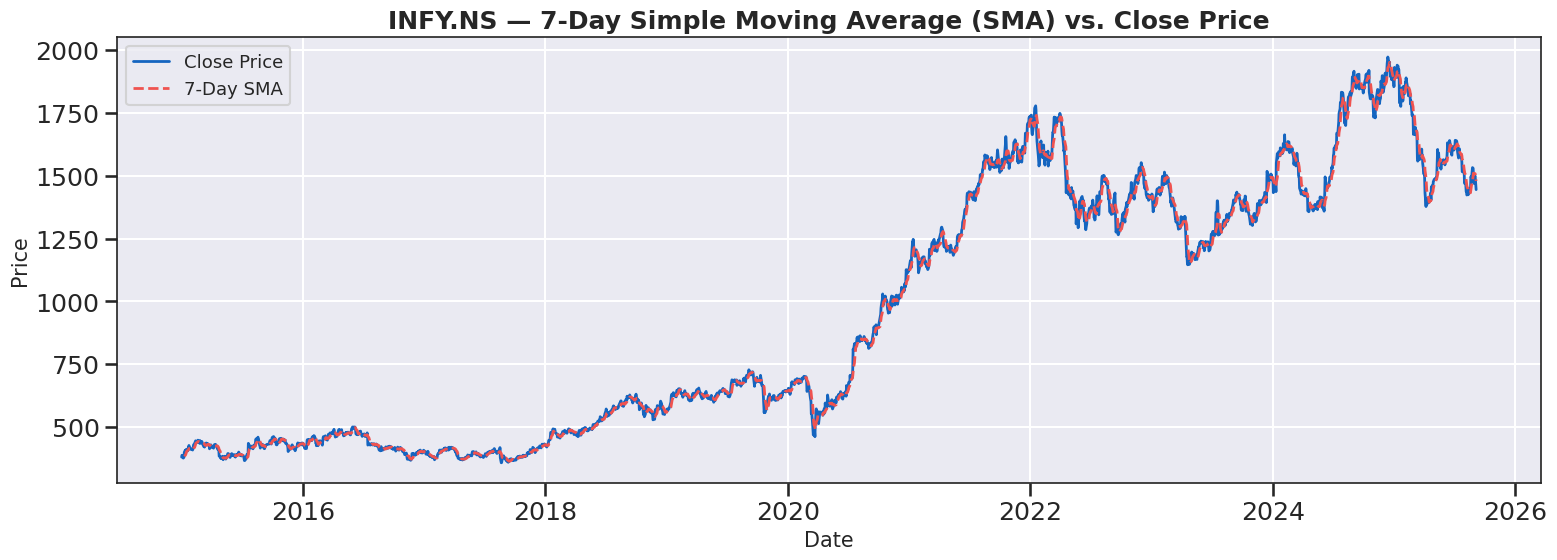

In [12]:
# Plotting and 7-day Simple Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["SMA_7"], label="7-Day SMA", color="#ef5350", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 7-Day Simple Moving Average (SMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

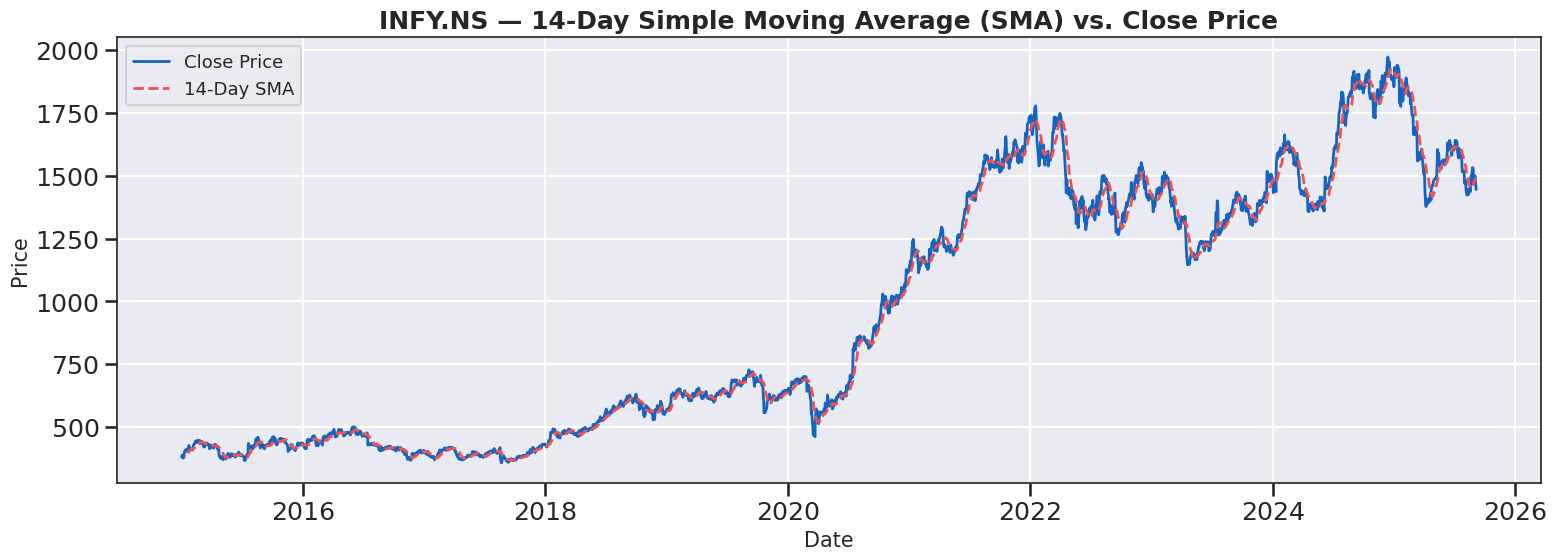

In [13]:
# Plotting and 14-day Simple Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["SMA_14"], label="14-Day SMA", color="#ef5350", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 14-Day Simple Moving Average (SMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

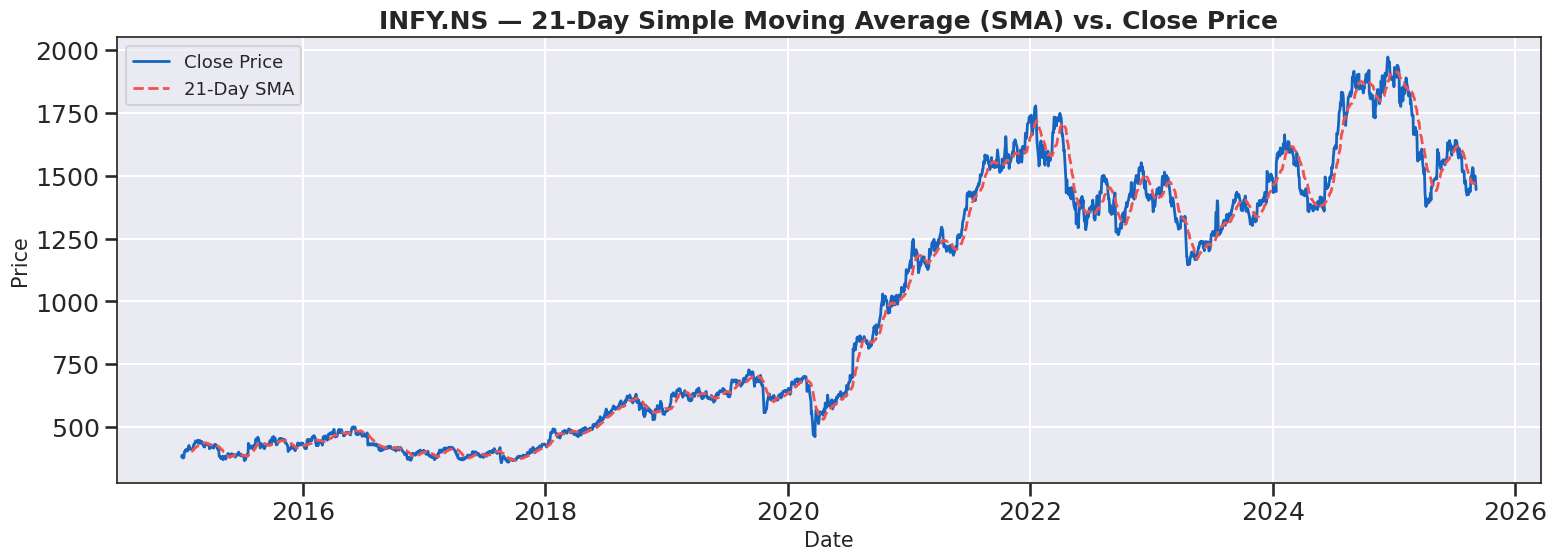

In [14]:
# Plotting and 21-day Simple Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["SMA_21"], label="21-Day SMA", color="#ef5350", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 21-Day Simple Moving Average (SMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

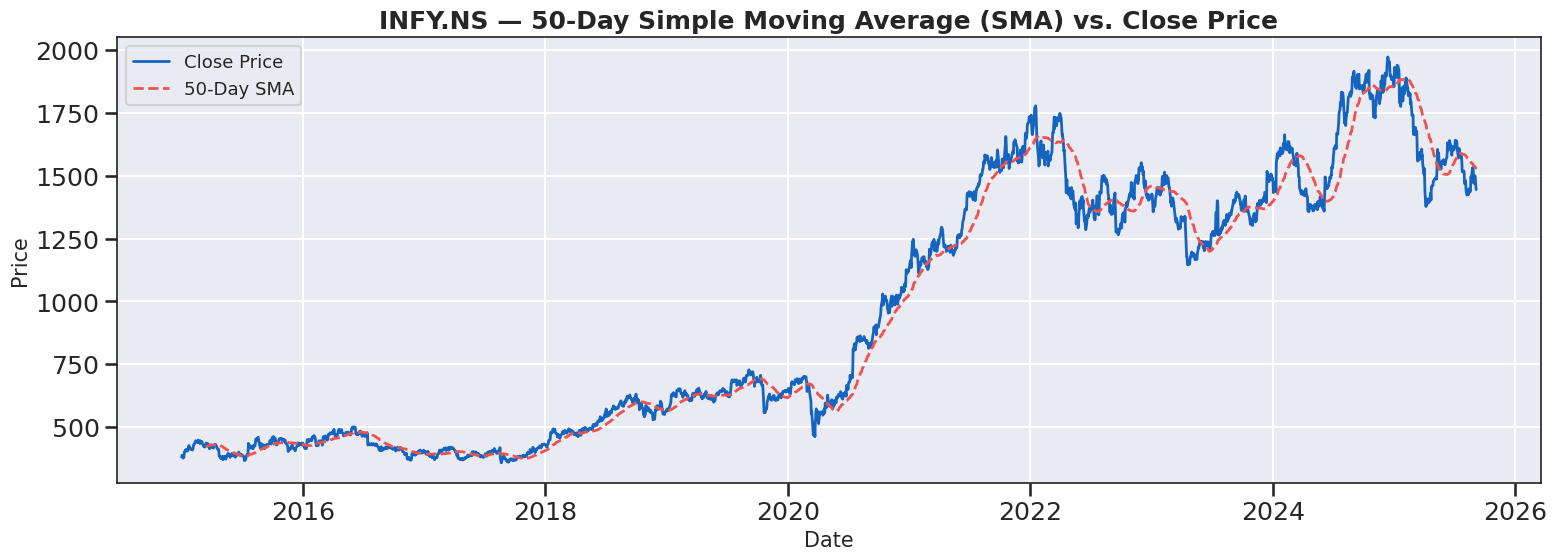

In [15]:
# Plotting and 50-day Simple Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["SMA_50"], label="50-Day SMA", color="#ef5350", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 50-Day Simple Moving Average (SMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

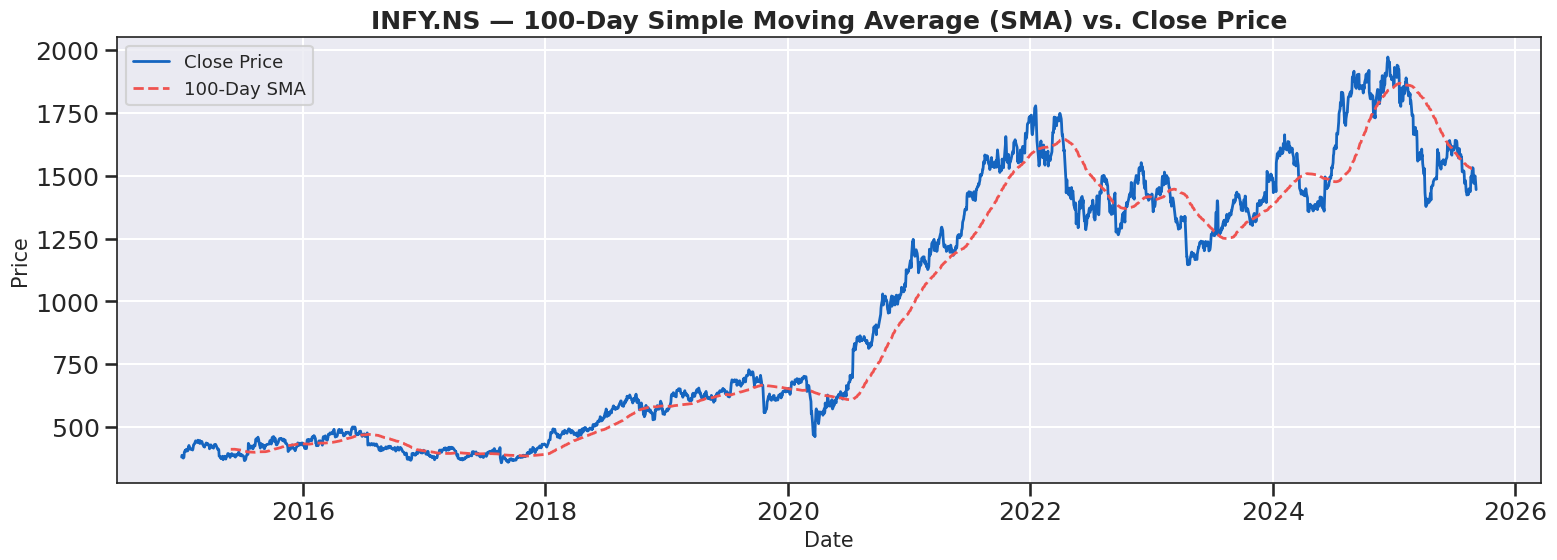

In [16]:
# Plotting and 100-day Simple Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["SMA_100"], label="100-Day SMA", color="#ef5350", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 100-Day Simple Moving Average (SMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

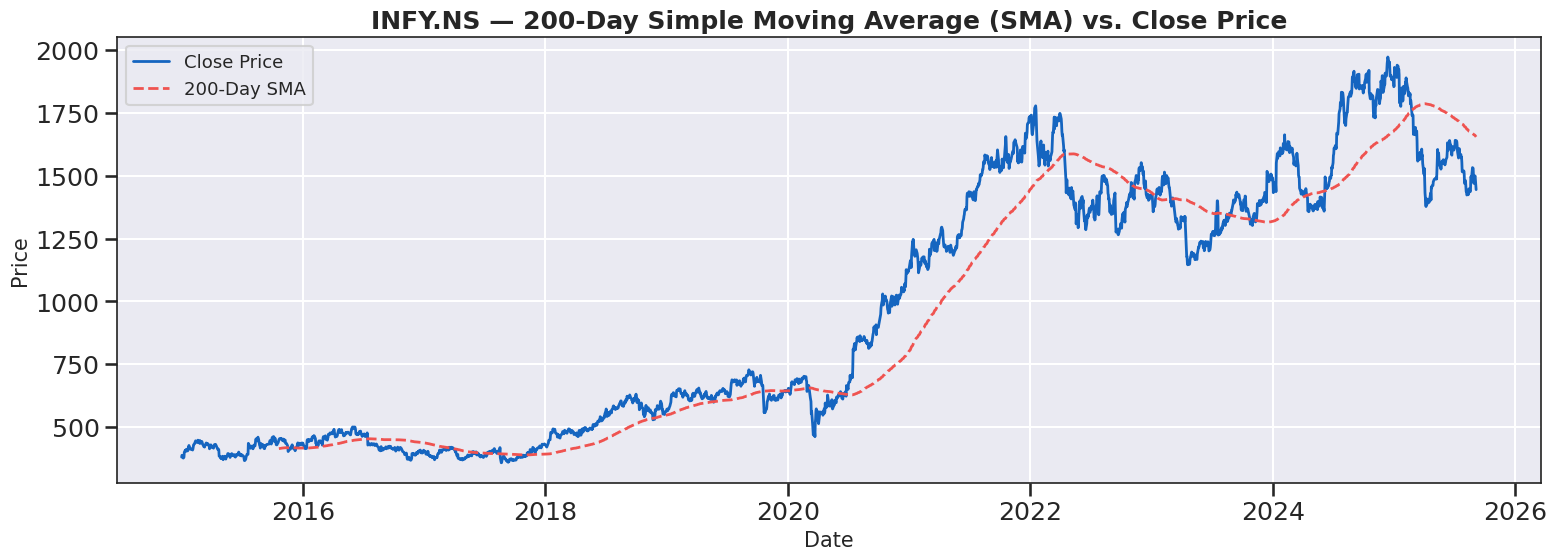

In [17]:
# Plotting and 200-day Simple Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["SMA_200"], label="200-Day SMA", color="#ef5350", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 200-Day Simple Moving Average (SMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

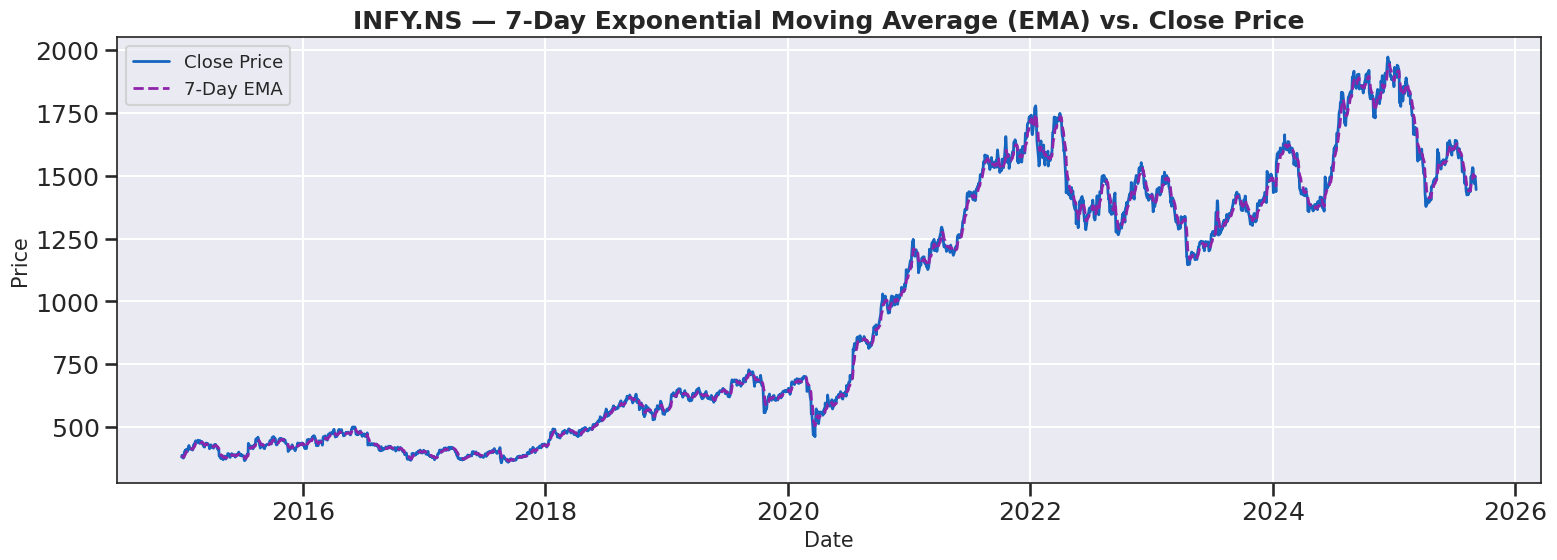

In [18]:
# Plotting and 7-day Exponential Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["EMA_7"], label="7-Day EMA", color="#8e24aa", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 7-Day Exponential Moving Average (EMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

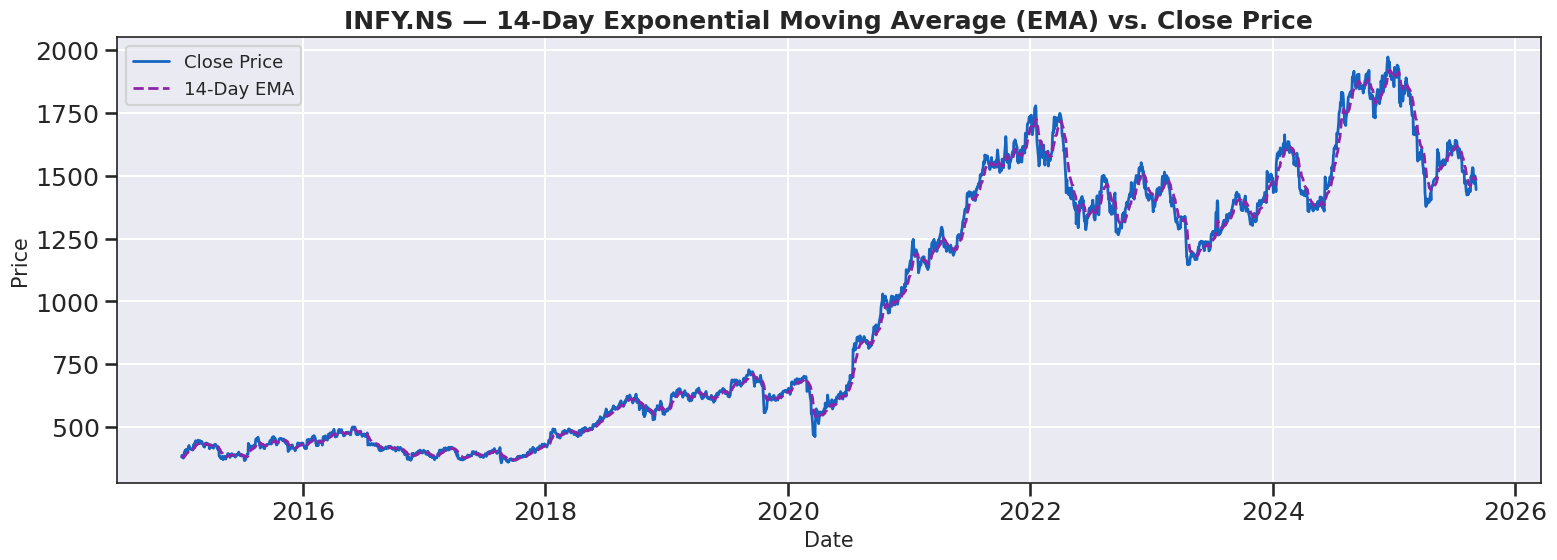

In [19]:
# Plotting and 14-day Exponential Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["EMA_14"], label="14-Day EMA", color="#8e24aa", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 14-Day Exponential Moving Average (EMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

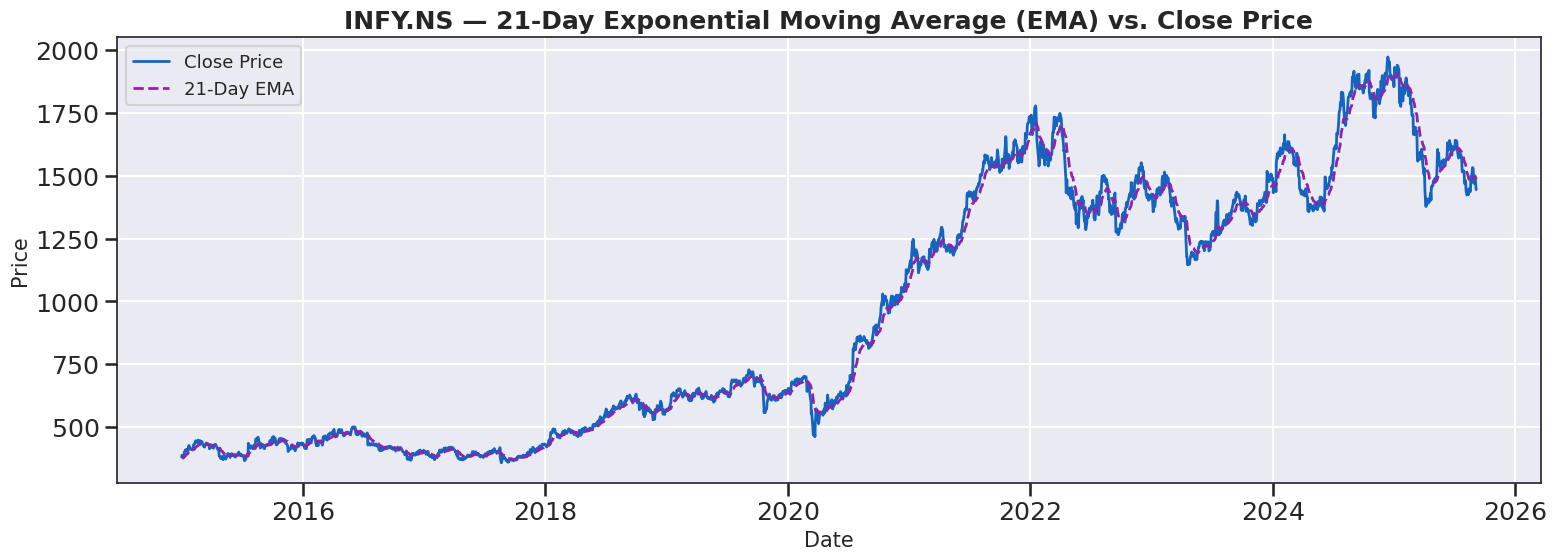

In [20]:
# Plotting and 21-day Exponential Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["EMA_21"], label="21-Day EMA", color="#8e24aa", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 21-Day Exponential Moving Average (EMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

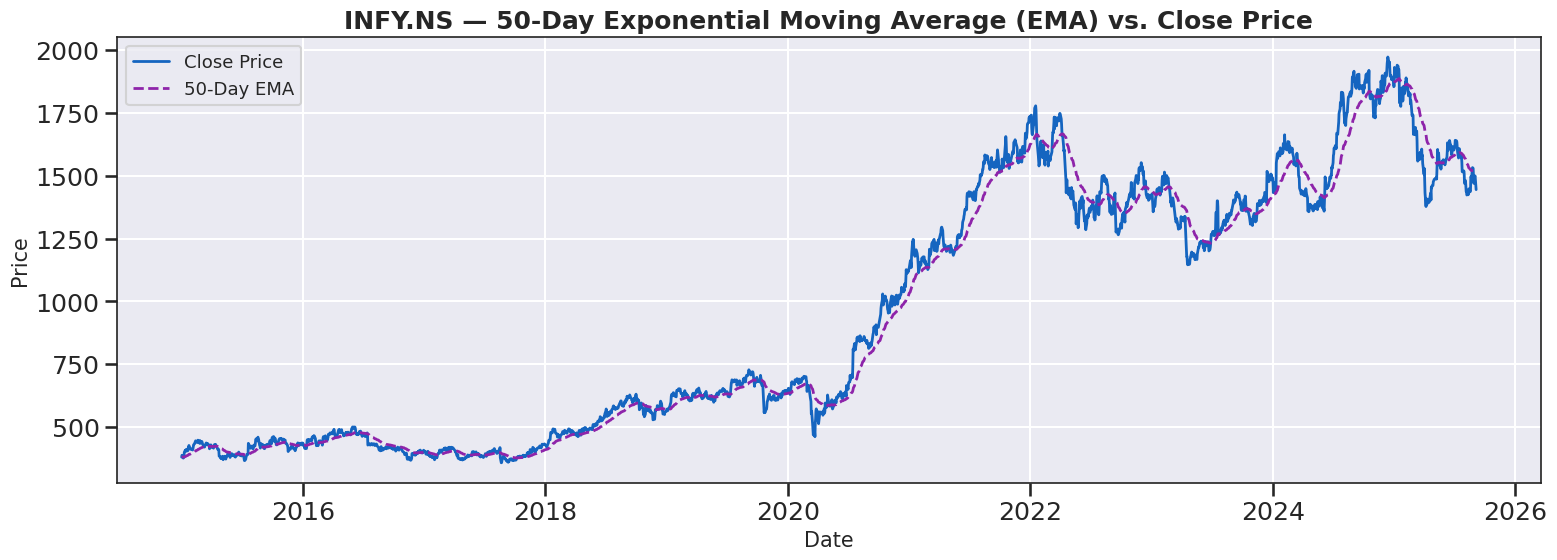

In [21]:
# Plotting and 50-day Exponential Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["EMA_50"], label="50-Day EMA", color="#8e24aa", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 50-Day Exponential Moving Average (EMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

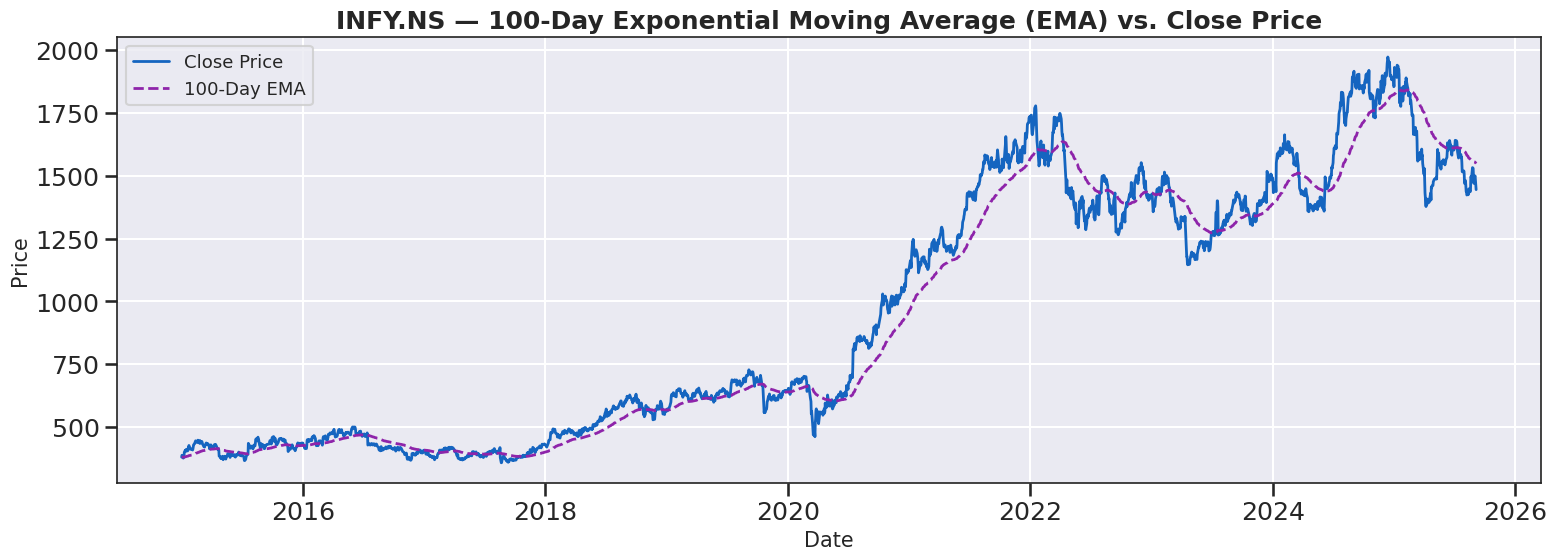

In [22]:
# Plotting and 100-day Exponential Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["EMA_100"], label="100-Day EMA", color="#8e24aa", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 100-Day Exponential Moving Average (EMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

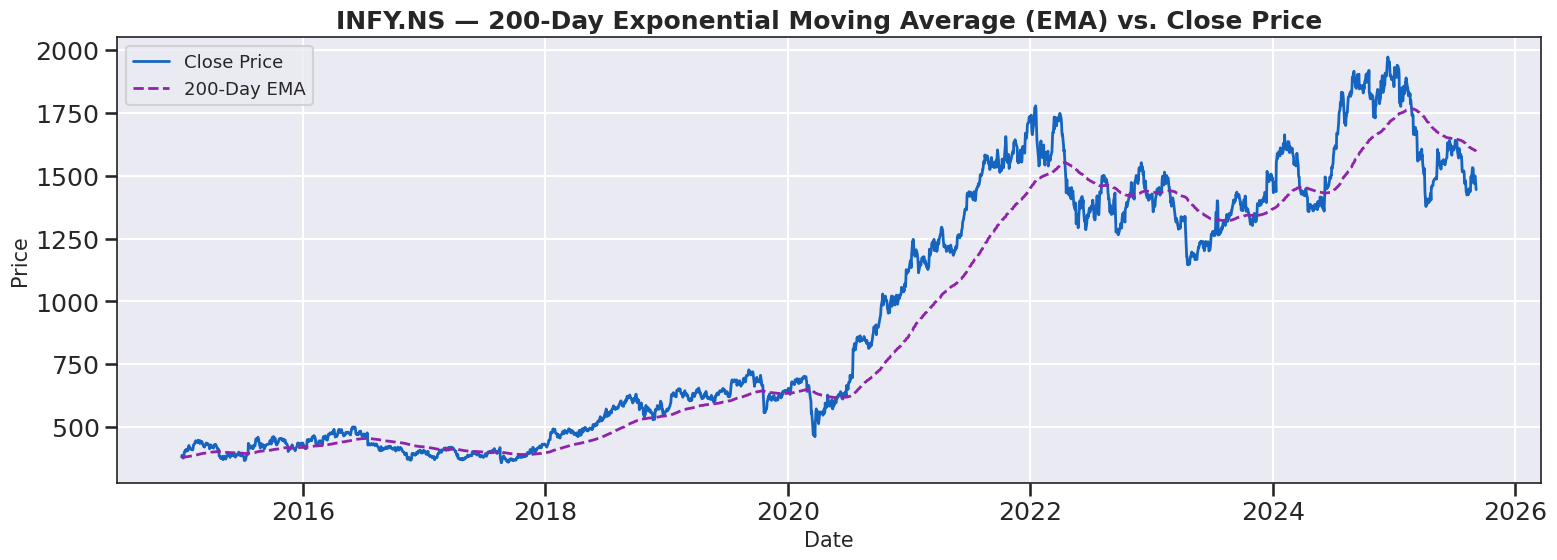

In [23]:
# Plotting and 200-day Exponential Moving Average

plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed["Close"], label="Close Price", color="#1565c0", linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed["EMA_200"], label="200-Day EMA", color="#8e24aa", linestyle="--", linewidth=2)
plt.title(f"{ticker} — 200-Day Exponential Moving Average (EMA) vs. Close Price", weight="bold")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

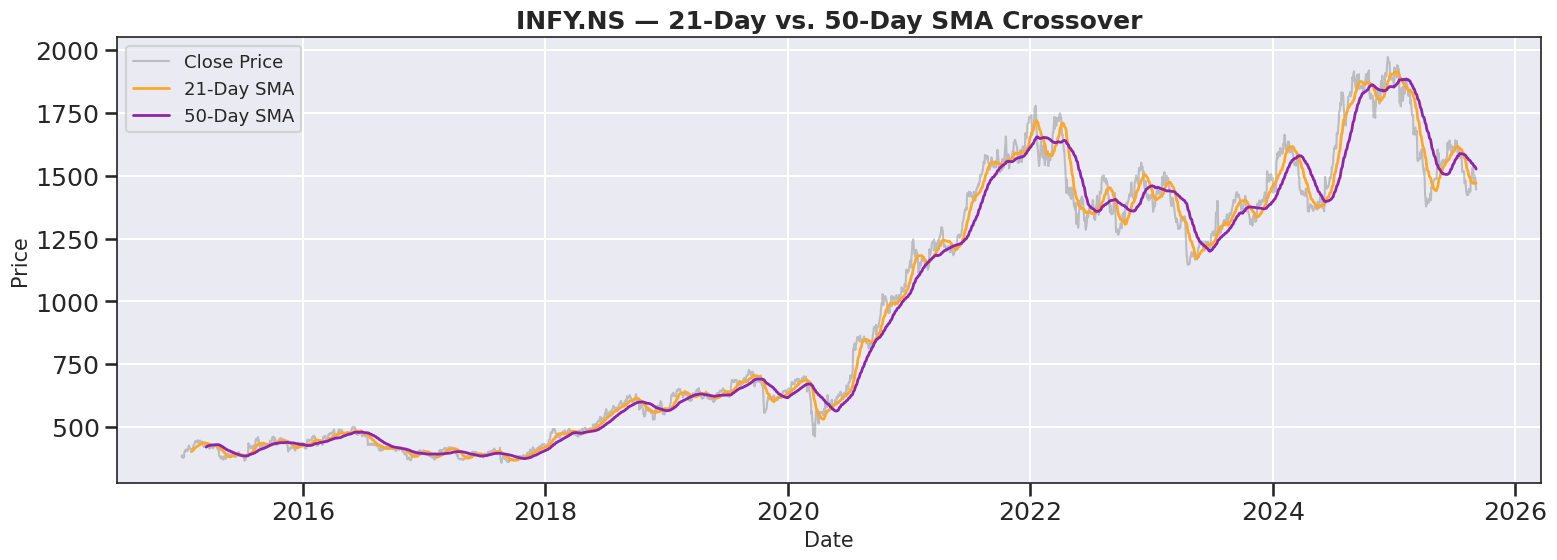

In [24]:
# Plotting Simple Moving Average Crossovers

# Crossover between 21 day SMA and 50 day SMA


plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed['Close'], label='Close Price', color='#757575', alpha=0.4, linewidth=1.5)
plt.plot(stock_preprocessed.index, stock_preprocessed['SMA_21'], label='21-Day SMA', color='#ffa726', linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed['SMA_50'], label='50-Day SMA', color='#8e24aa', linewidth=2)
plt.title(f'{ticker} — 21-Day vs. 50-Day SMA Crossover', weight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()


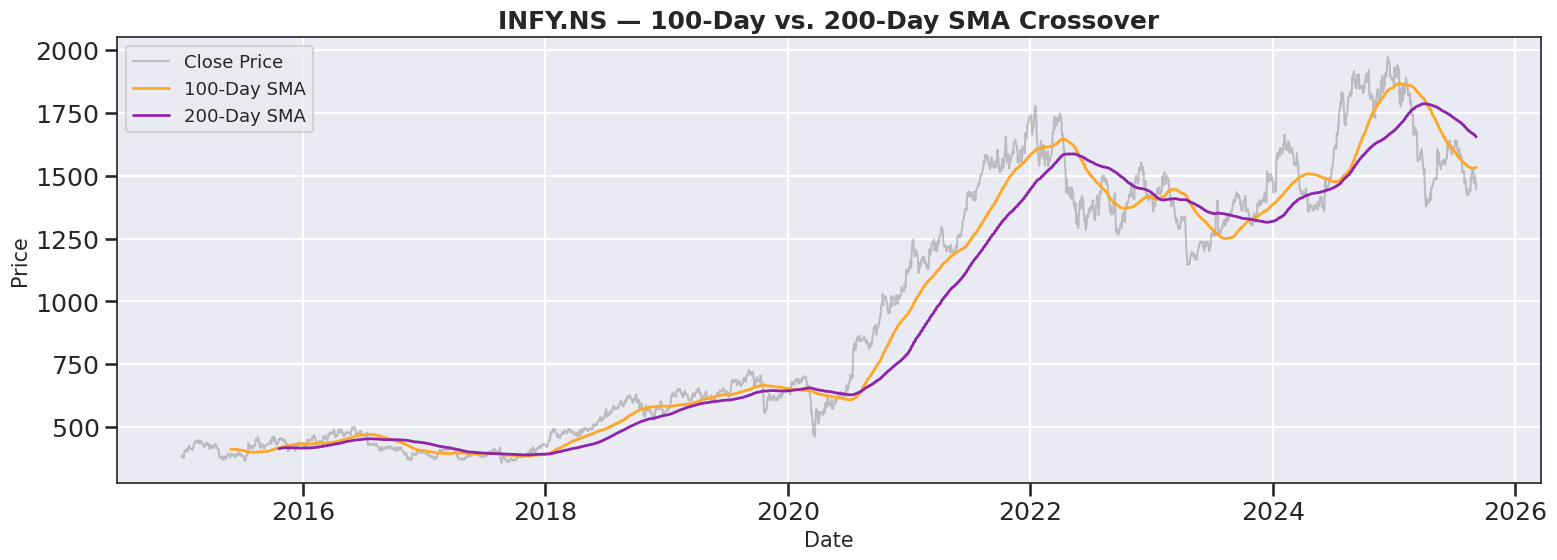

In [25]:
# Plotting Simple Moving Average Crossovers

# Crossover between 100 day SMA and 200 day SMA


plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed['Close'], label='Close Price', color='#757575', alpha=0.4, linewidth=1.5)
plt.plot(stock_preprocessed.index, stock_preprocessed['SMA_100'], label='100-Day SMA', color='#ffa726', linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed['SMA_200'], label='200-Day SMA', color='#8e24aa', linewidth=2)
plt.title(f'{ticker} — 100-Day vs. 200-Day SMA Crossover', weight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()


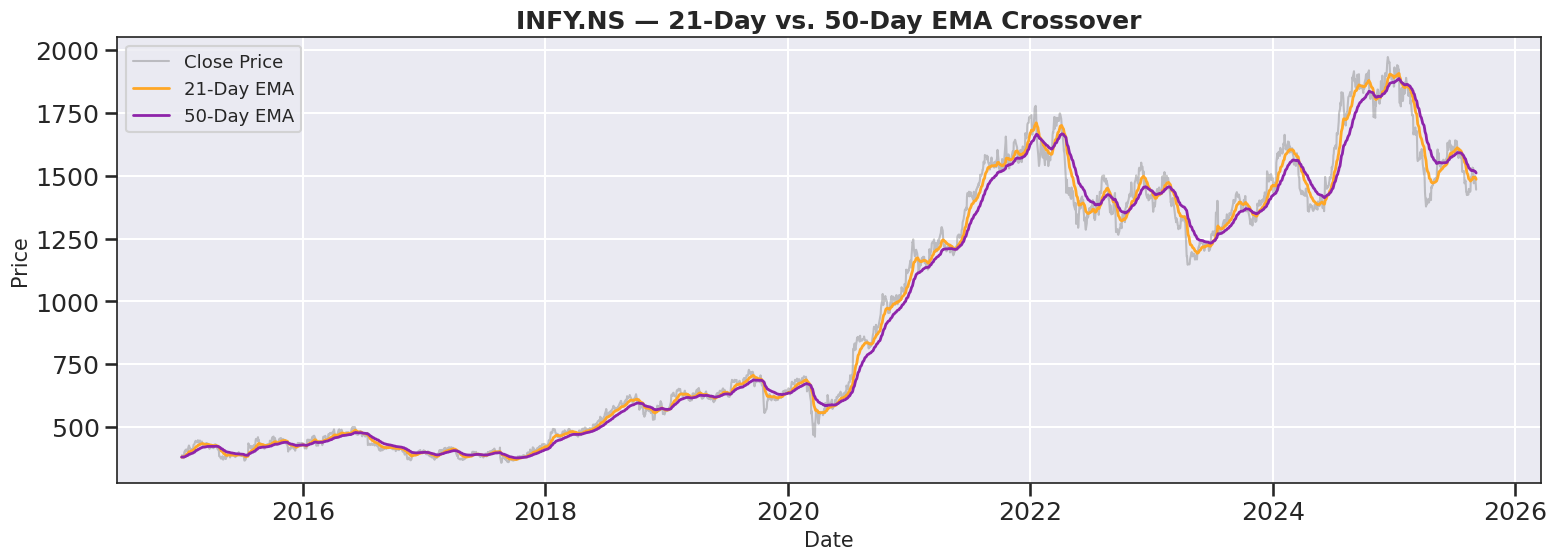

In [26]:
# Plotting Exponential Moving Average Crossovers

# Crossover between 21 day EMA and 50 day EMA


plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed['Close'], label='Close Price', color='#757575', alpha=0.4, linewidth=1.5)
plt.plot(stock_preprocessed.index, stock_preprocessed['EMA_21'], label='21-Day EMA', color='#ffa726', linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed['EMA_50'], label='50-Day EMA', color='#8e24aa', linewidth=2)
plt.title(f'{ticker} — 21-Day vs. 50-Day EMA Crossover', weight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()


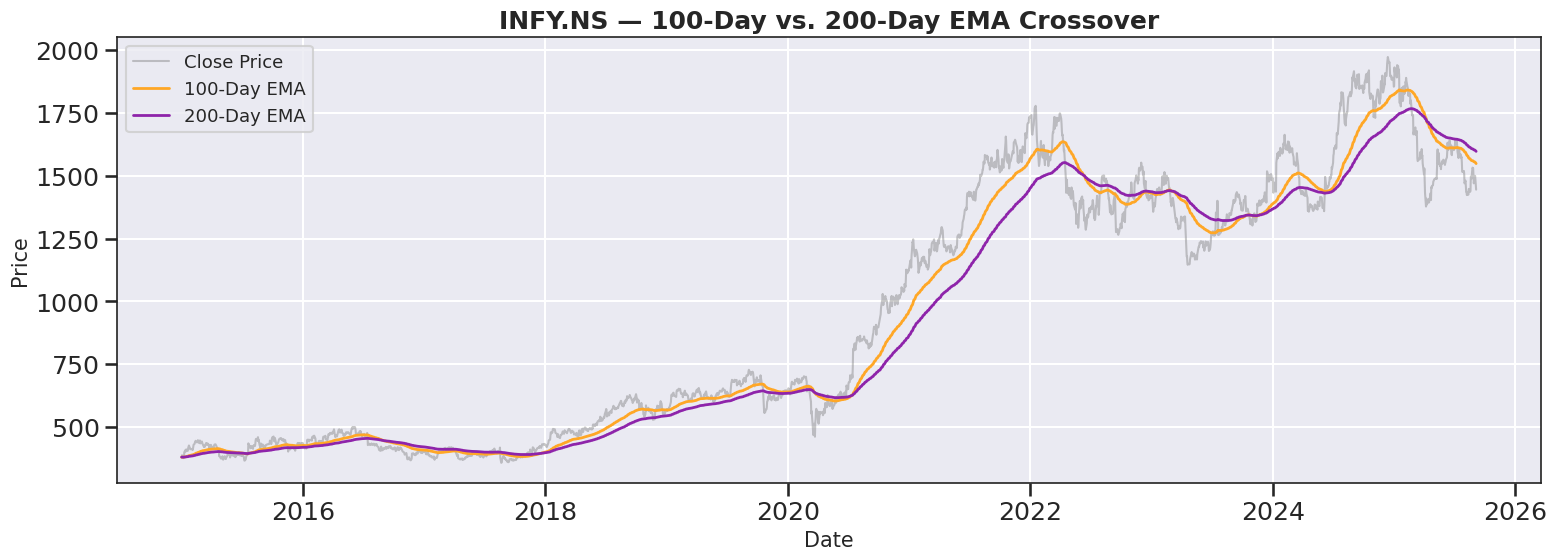

In [27]:
# Plotting Exponential Moving Average Crossovers

# Crossover between 100 day EMA and 200 day EMA


plt.figure(figsize=(16, 6))
plt.plot(stock_preprocessed.index, stock_preprocessed['Close'], label='Close Price', color='#757575', alpha=0.4, linewidth=1.5)
plt.plot(stock_preprocessed.index, stock_preprocessed['EMA_100'], label='100-Day EMA', color='#ffa726', linewidth=2)
plt.plot(stock_preprocessed.index, stock_preprocessed['EMA_200'], label='200-Day EMA', color='#8e24aa', linewidth=2)
plt.title(f'{ticker} — 100-Day vs. 200-Day EMA Crossover', weight='bold')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()


# **Train Test Split**

In [28]:
# Divinding data(features) into train and test splits

# Drop any rows with NaNs in features or target
data_clean = stock_preprocessed.dropna()

# Then split
X = data_clean.drop(columns=['Close'])
y = data_clean['Close'].shift(-1)  # tomorrow's Close
X = X.iloc[:-1]
y = y.iloc[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [29]:
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

Training set: (1949, 39), Test set: (488, 39)


# **Standardization**

In [30]:
# Standardizing the data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Standardization Complete")

Standardization Complete


# **Hyperparameter Tuning**

In [91]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb

# Base XGBRegressor with GPU enabled
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="gpu_hist",       # 🔥 enables GPU training
    predictor="gpu_predictor"     # optional, speeds up inference
)

param_grid = {
    "n_estimators": [200, 500, 800],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # RMSE but negative
    cv=tscv,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (MSE):", grid_search.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV Score (MSE): -61785.430596778555


# **Model Evaluation**

In [33]:
# Training Model on best Parameters

best_params = {
    "n_estimators": 200,
    "learning_rate": 0.1,
    "max_depth": 3,
    "subsample": 1.0,
    "colsample_bytree": 0.6,
    "random_state": 42,
    "tree_method": "hist"  # CPU-friendly
}

xgb_model = xgb.XGBRegressor(**best_params)

xgb_model.fit(X_train_scaled, y_train)

y_pred = xgb_model.predict(X_test_scaled)

In [34]:
# Evaluating Model based on Metrics

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

Model Performance on Test Set:
RMSE: 102.5852
MAE: 69.2919
R²: 0.6943


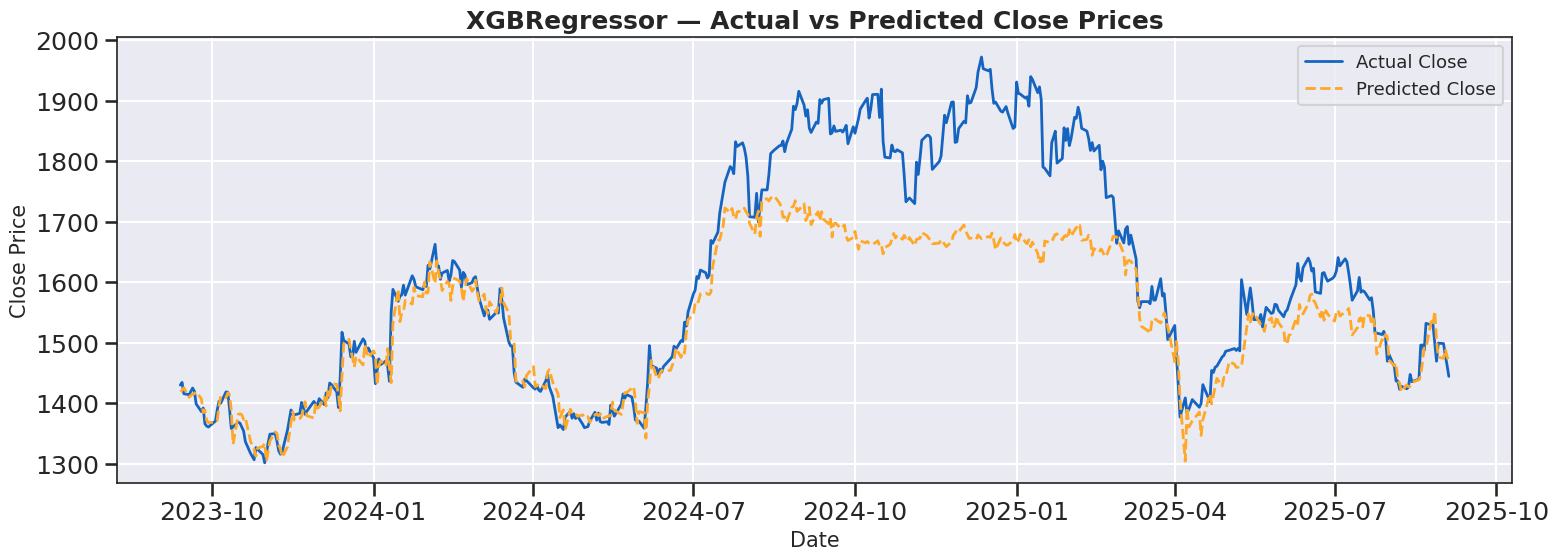

In [35]:
# Plotting thePerformance of Model

plt.figure(figsize=(16,6))
plt.plot(y_test.index, y_test.values, label='Actual Close', color='#1565c0', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted Close', color='#ffa726', linewidth=2, linestyle='--')
plt.title("XGBRegressor — Actual vs Predicted Close Prices", weight='bold')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(frameon=True, fancybox=True)
plt.tight_layout()
plt.show()

# **Compare with Indian Benchmark Index NIFTY50**


Comparing INFY.NS performance with benchmark ^NSEI...


[*********************100%***********************]  1 of 1 completed


Data downloaded successfully.


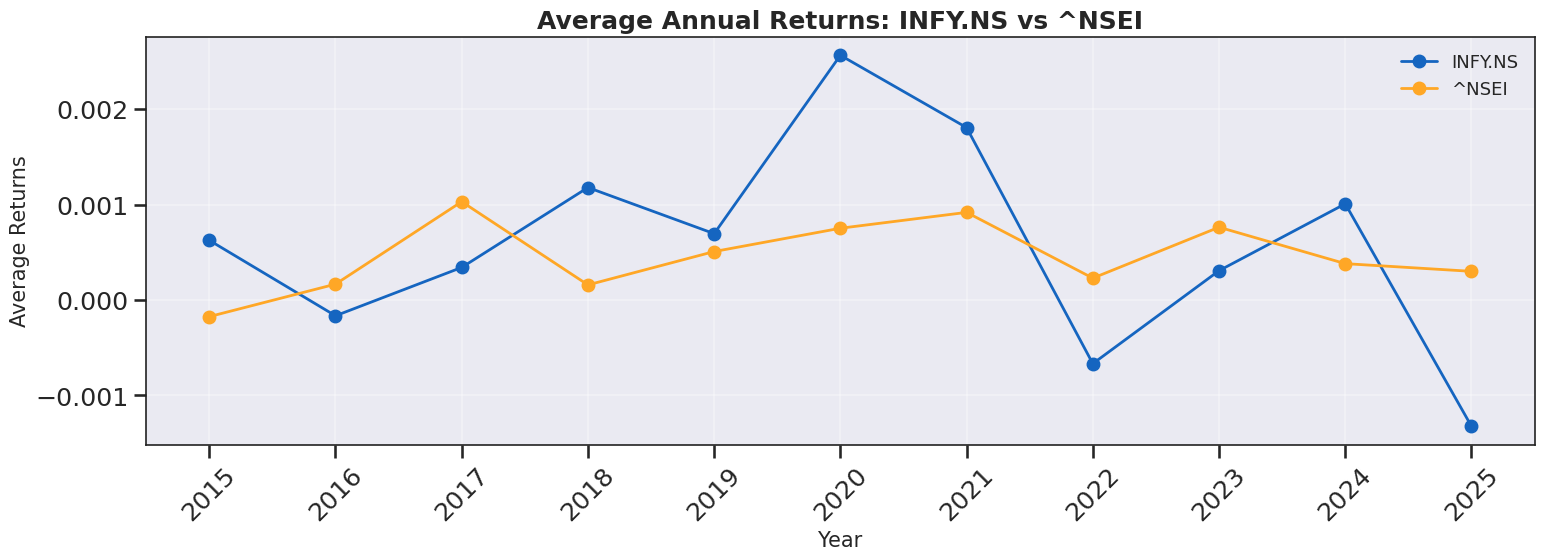


--- Investment Conclusion ---
Over the period from 2015-01-02 to 2025-09-05:
Total Cumulative Return for INFY.NS: 272.21%
Total Cumulative Return for ^NSEI: 194.70%



<div style='background:#e8f5e9;padding:16px;border-radius:10px;'><strong style='font-size:1.2em;color:#2e7d32;'>Recommendation:</strong> Investing in <span style='color:#1565c0'>INFY.NS</span> would have been more beneficial than investing in <span style='color:#ffa726'>^NSEI</span> during this period.</div>

In [36]:
# Function to compare our ticker and benchmark index

def compare_with_benchmark(stock_df, stock_ticker, benchmark_ticker, start_date, end_date):
    """
    Compares the stock's average annual returns against a benchmark index (Nifty 50)
    and plots the comparison.

    Args:
        stock_df (pd.DataFrame): The DataFrame of the user's stock.
        stock_ticker (str): The ticker symbol of the user's stock.
        benchmark_ticker (str): Ticker of the benchmark index.
        start_date (str): Analysis start date.
        end_date (str): Analysis end date.
    """
    print(f"\nComparing {stock_ticker} performance with benchmark {benchmark_ticker}...")

    # Download benchmark data
    benchmark_df = download_stock_data(benchmark_ticker, start_date, end_date)
    if benchmark_df is None:
        print("Benchmark data not available.")
        return

    # Align date ranges
    start = max(stock_df.index.min(), benchmark_df.index.min())
    end = min(stock_df.index.max(), benchmark_df.index.max())
    stock_aligned = stock_df.loc[start:end].copy()
    benchmark_aligned = benchmark_df.loc[start:end].copy()

    # Compute daily returns
    stock_aligned['Returns'] = stock_aligned['Close'].pct_change()
    benchmark_aligned['Returns'] = benchmark_aligned['Close'].pct_change()

    # Add Year column
    stock_aligned['Year'] = stock_aligned.index.year
    benchmark_aligned['Year'] = benchmark_aligned.index.year

    # Compute average annual returns
    avg_stock_returns = stock_aligned.groupby('Year')['Returns'].mean()
    avg_benchmark_returns = benchmark_aligned.groupby('Year')['Returns'].mean()

    # Combine into one DataFrame and drop missing years
    returns_comparison = pd.DataFrame({
        'Stock': avg_stock_returns,
        'Benchmark': avg_benchmark_returns
    }).dropna()

    # Plot average annual returns
    plt.figure(figsize=(16,6))
    plt.plot(returns_comparison.index, returns_comparison['Stock'], marker='o', color='#1565c0', linewidth=2, label=stock_ticker)
    plt.plot(returns_comparison.index, returns_comparison['Benchmark'], marker='o', color='#ffa726', linewidth=2, label=benchmark_ticker)
    plt.title(f'Average Annual Returns: {stock_ticker} vs {benchmark_ticker}', weight='bold')
    plt.xlabel('Year')
    plt.ylabel('Average Returns')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(returns_comparison.index, rotation=45)
    plt.tight_layout()
    plt.show()

    # Cumulative returns for conclusion
    stock_cum_return = (1 + stock_aligned['Returns']).cumprod().iloc[-1] - 1
    benchmark_cum_return = (1 + benchmark_aligned['Returns']).cumprod().iloc[-1] - 1

    print("\n--- Investment Conclusion ---")
    print(f"Over the period from {start.date()} to {end.date()}:")
    print(f"Total Cumulative Return for {stock_ticker}: {stock_cum_return:.2%}")
    print(f"Total Cumulative Return for {benchmark_ticker}: {benchmark_cum_return:.2%}\n")

    # Recommendation
    if stock_cum_return > benchmark_cum_return:
        recommendation = (
            f"<div style='background:#e8f5e9;padding:16px;border-radius:10px;'>"
            f"<strong style='font-size:1.2em;color:#2e7d32;'>Recommendation:</strong> "
            f"Investing in <span style='color:#1565c0'>{stock_ticker}</span> would have been more beneficial "
            f"than investing in <span style='color:#ffa726'>{benchmark_ticker}</span> during this period."
            f"</div>"
        )
    else:
        recommendation = (
            f"<div style='background:#fff3e0;padding:16px;border-radius:10px;'>"
            f"<strong style='font-size:1.2em;color:#b53d00;'>Recommendation:</strong> "
            f"Investing in <span style='color:#ffa726'>{benchmark_ticker}</span> would have been more beneficial "
            f"than investing in <span style='color:#1565c0'>{stock_ticker}</span> during this period."
            f"</div>"
        )

    display(Markdown(recommendation))


# Calling the function

compare_with_benchmark(stock_preprocessed, ticker, "^NSEI", start_date, end_date)

# **Conclusion**

In this project, we successfully developed a predictive pipeline for stock price forecasting using historical data and machine learning techniques. Key achievements include:


**Data Collection & Preprocessing**: Historical stock data and benchmark index (Nifty50) data were collected, cleaned, and feature-engineered, including returns, lag features, rolling statistics, and moving averages.


**Modeling & Forecasting**: An XGBoost Regressor was trained and tuned to predict stock closing prices. The model achieved satisfactory performance on the test set with an RMSE of ~102, MAE of ~69, and R² of ~0.70, indicating reliable predictive capability.


**Portfolio Benchmarking**: The stock’s performance was compared with Nifty50 using cumulative and average annual returns. This provided insights into periods where investing in the stock outperformed the market benchmark.


**Investment Insights**: The analysis enables informed decision-making, showing whether the stock is likely to provide better returns than the benchmark and identifying potential buy signals based on forecasts.


**Future Scope**: The framework can be extended to multi-stock portfolio optimization, incorporate risk-adjusted metrics, or integrate real-time predictions for automated trading strategies.


Overall, this project demonstrates how machine learning can be leveraged for predictive stock analytics and benchmark-based portfolio decisions, providing both actionable insights and a foundation for more advanced quantitative finance applications.